<a href="https://colab.research.google.com/github/MonetSlinowsky/ants-packing-bins/blob/master/MY_transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


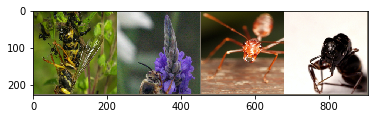

Epoch 0/34
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6735 Acc: 0.6107
val Loss: 0.4422 Acc: 0.8497

Epoch 1/34
----------
train Loss: 0.5131 Acc: 0.7828
val Loss: 0.2999 Acc: 0.9150

Epoch 2/34
----------
train Loss: 0.4745 Acc: 0.7746
val Loss: 0.2643 Acc: 0.9216

Epoch 3/34
----------
train Loss: 0.4260 Acc: 0.7910
val Loss: 0.2363 Acc: 0.9216

Epoch 4/34
----------
train Loss: 0.4033 Acc: 0.8320
val Loss: 0.2145 Acc: 0.9281

Epoch 5/34
----------
train Loss: 0.4073 Acc: 0.8156
val Loss: 0.2050 Acc: 0.9346

Epoch 6/34
----------
train Loss: 0.3445 Acc: 0.8730
val Loss: 0.2006 Acc: 0.9281

Epoch 7/34
----------
train Loss: 0.4081 Acc: 0.8115
val Loss: 0.1943 Acc: 0.9281

Epoch 8/34
----------
train Loss: 0.3570 Acc: 0.8607
val Loss: 0.2227 Acc: 0.9281

Epoch 9/34
----------
train Loss: 0.3529 Acc: 0.8443
val Loss: 0.1946 Acc: 0.9346

Epoch 10/34
----------
train Loss: 0.4106 Acc: 0.8033
val Loss: 0.1875 Acc: 0.9346

Epoch 11/34
----------
train Loss: 0.4431 Acc: 0.7664
val Loss: 0.1911 Acc: 0.9281

Epoch 12/34
----------
t

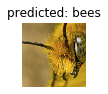

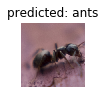

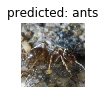

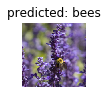

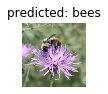

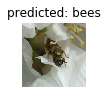

In [0]:
from __future__ import print_function, division
import torch #ML library
import torch.nn as nn #NN library
import torch.optim as optim # optimizer library?
from torch.optim import lr_scheduler #allows for dynamic learning rate
import numpy as np #for dealing with matrices
import torchvision #prepackaged algs
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt #for plotting
import time
import os #allows you to interact with underlying operating sys
import copy

from google.colab import drive
drive.mount('/content/gdrive')

plt.ion() #interactive plotting mode (?)

# Loading data

# Data augmentation and normalization for training
#Just normalization for validation

#When we import the data, we're going to transform it in the following ways
# Chaining together common image transformations

#Different transforms for the training and validation sets
#This is a dictionary 


data_transforms = {  
    'train': transforms.Compose([
         transforms.RandomResizedCrop(224), #crop of random size and aspect ratios, the 224 is the expected output size maybe??
         transforms.RandomHorizontalFlip(), #flip horizontally with given probability
         transforms.ToTensor(), #Converts to the 'Tensor' type 
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ??? Calculated mean and std dev                     
    ]),
    'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/gdrive/My Drive/Colab Notebooks/hymenoptera_data' #data directory for this tutorial #data directory for this tutorial

# This is a dictionary generator

# Iteration through 'train' and 'val'
# This applies the data transforms to the images in datasets.ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']} 
                  #datasets function -used to read and transform data point from given dataset

                
# A dataloader is a Python iterator over a dataset
# Used to shuffle, batch data, load data in parallel with multiprocessing workers
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                  for x in ['train', 'val']
               #image_datasets[x] incidates from which set data should be loaded 
               # batch_size =4 how many samples per batch to load, is used to construct a batch sampler, which provides the indices that should be fetched
               # shuffle - randomly shuffles data each epoch
               # workers - how many subprocesses to use for data loading

}
# ??? not sure if this is a map-style or iterable-style dataset

#Getting the sizes of training and validation sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#Get the class labels for the training set
class_names = image_datasets['train'].classes 

# Use cuda GPU if available, otherwise sitkc with CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Now visualize some images
def imshow(inp, title=None):
  #Assuming inp is the input
  inp = inp.numpy().transpose((1,2,0)) #Change from a tensor to a numpy array and permutes the axis according to the given ints 
  mean = np.array([0.485, 0.456, 0.406]) #These are predetermined from the images?
  std = np.array([0.229, 0.224, 0.225]) #Given std
  inp = std * inp + mean #Normalizing the input...?

  inp=np.clip(inp, 0, 1) # Limits the values in the given array. Interval values outside the interval edges are clipped to interval edges
  plt.imshow(inp)
  #if title is not None
   # plt.title(title)
  plt.pause(0.001)

#Get a batch of training data
inputs, classes=next(iter(dataloaders['train'])) #Dataloaders is an iterable
  #We're looking at the training data. iter() creates the iterator from it, next() grabs the next one

#Make a grid from batch 
out = torchvision.utils.make_grid(inputs)

#Display the image 
imshow(out, title=[class_names[x] for x in classes])


# !!!! Model training !!!!
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  #model is the built-in model we're using
  # criterion - the loss function?
  # optimizer - the optimizer we're using ie SGD or whatever
  # scheduler - LR scheduler object...automatic learning rate update and step
  
  since=time.time() #timestamp????

  best_model_wts = copy.deepcopy(model.state_dict()) 
      #model.state_dict is a Python dictionary object that maps each layer to its parameter tensor
      # ie to the learnable parameters of that layer 
      # This is creating a deep copy of that dictionary object

  best_acc = 0.0 # ??????

  for epoch in range(num_epochs):
    #For each epoch
    print('Epoch {}/{}'.format(epoch, num_epochs -1)) # Print which epoch we are on out of total # (-1 b/c we start at 0)
    print ('-' * 10) # ??? printing....something

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']: 
      if phase == 'train': #self explanatory
        # ???????
        scheduler.step() # does this update the learning rate?
        model.train() # Set model to training mode
      else:
        model.eval() #set to evaluation mode

      running_loss = 0.0 
      running_corrects = 0 

      # Iterate over data 
      for inputs, labels in dataloaders[phase]: #for the inputs in 'train' or 'val' depending on what 'phase' is
        #inputs are the actual images with the matrices and labels are the labels
        inputs = inputs.to(device) #is this sending the inputs to the device? ie cuda?
        labels = labels.to(device)

      # zero the parameter gradients
      # yeah but what is this doing mathematically???
        optimizer.zero_grad()

      # forward prop 
      
        with torch.set_grad_enabled(phase == 'train'): # Enables gradient tracking only when 'train' to save mem/time etc
          outputs = model(inputs) # Get results from existing model
          _, preds = torch.max(outputs, 1) # Get predictions (max score is the predicted class)
          loss = criterion(outputs, labels) # Calculate loss (how good)

          if phase == 'train':
            loss.backward() #calculates the gradients (values using the internal function map thing)
            optimizer.step() #updates parameters (one 'step') using partial derivs

          # statistics
          running_loss += loss.item() * inputs.size(0) 
            # loss.item() gets the Python number from the tensor
            # inputs.size(0) should give the batch size
            # This is the calculated loss weighted by the number of amples
          running_corrects += torch.sum(preds == labels.data) #number of correct predictions

      # Total loss for the epoch
      epoch_loss = running_loss / dataset_sizes[phase] # average loss/weighted (average) loss
      epoch_acc = running_corrects.double() / dataset_sizes[phase] # ?? Why double this??
        # This is giving average number of correct answers (I think)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc)) #Print the phase and the statistics
      
      # deep copy the model .... parameters have been updated
      if phase == 'val' and epoch_acc >> best_acc:
      # Create a copy only if this model is on VAL data AND accuracy is better than current best
          best_acc = epoch_acc #updates
          best_model_wts = copy.deepcopy(model.state_dict())
  
    print()

    # Get the total time it took to train
  time_elapsed=time.time() - since
      #Print results
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed //60, time_elapsed % 60))
  print('Best val Acc: {}'.format(best_acc))

    # save best model weights in a dictionary - this is what we need when we want to load model again in future
  model.load_state_dict(best_model_wts)
  return model

# This is a generic function to display predictions for a few images
def visualize_model(model, num_images=6):
  was_training = model.training # I think this saves the current 'state' of the model as either true or false
  model.eval() # kinda puts it in evaluation mode so we know we're not training
  images_so_far=0
  fig=plt.figure()

  with torch.no_grad(): #don't carry gradients with anything - I think we just do this to save space/time
    for i, (inputs, labels) in enumerate(dataloaders['val']): #for all elements of the val set
      #not entirely sure why we're enumerating...?
   
   # Make stuff available to the dev
      inputs = inputs.to(device)
      labels = labels.to(device)

      # go through arch (fwd)
      outputs = model(inputs)

      # Make predictions ... max does soft max 
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]): # iterating over 
        images_so_far+= 1 # adding another image
        ax = plt.subplot(num_images//2, 2, images_so_far) #creating our axis, for multiple images to be displayed at a time
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]])) # the prediction for this input
        imshow(inputs.cpu().data[j]) #show the data ... on the cpu not on device

        if images_so_far ==num_images: # we should stop when we get to 6 
          model.train(mode=was_training) # This sets the state to what it was previously (before eval mode)
          return

      model.train(mode=was_training)



# Fine-tuning the convnet
model_ft = models.resnet18(pretrained=True) # Load the resnet architecture model that's pretrained
num_ftrs = model_ft.fc.in_features # Get the number of output features of the CNN (ie the number of in-features to the fully connected layer)
model_ft.fc = nn.Linear(num_ftrs, 2) # This is creating 1 new fully connected layer with the # of input features and 2 output features

model_ft = model_ft.to(device) #sending parameters and such to device

# Specify the lost function
criterion = nn.CrossEntropyLoss()

#Specify optimizer (Stochastic gradient descenet)
# lr is learning rate
# momentum is used to improve gradient descent (and overcome ravine issues)
  # accumulates the gradient of the past steps to determine the direction to go
  # the coefficient of momentum is the percentage of the gradient retrained every iteration
  # dampens oscillations in our search
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

#Note: all parameters are being optimized (as opposed to freezing)

# Decay LR by a factor of 0.1 every 7 epochs
# multiplying our currently lr by 0.1 (this makes it much much smaller)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=35)
visualize_model(model_ft)




In [0]:
# Using as a fixed feature extractor

# this is probably the first try we want to do for our alg

#The change here is we freeze all layers except the final layer

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False # so this freezes the parameters so gradients are not calculated when we do backward()


# Params of newly constructed modules have requires_grad= True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2) #new fully connected layer

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# now only final parameters being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# recall: momentum is used to accumulate past gradients, which helps minimize zigzagging, allowing for faster convergence (ideally)

# decay LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Get the model wooooo!!
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)
plt.ioff()
plt.show()

